In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.fftpack import fft2, ifft2
from tqdm import tqdm

#Complexification

In [2]:
# Constantes physiques
R = 287.05  # Constante des gaz parfaits air sec, J/(kg·K)
Cp = 1005.0  # Capacité thermique à pression constante, J/(kg·K)
kappa = R / Cp  # Rapport des constantes
f = 1e-4  # Paramètre de Coriolis
g = 9.81
dx = dy = 1.0
dt = 0.1

# Initialisation des variables
def initial_conditions(grid_size):
    """
    Initialise des conditions avec :
    - Une dépression au centre de la grille.
    - Une température plus faible au centre.
    - Une divergence négative au centre.
    - Une humidité plus faible au centre.
    - Une vorticité nulle partout.
    """
    nx, ny = grid_size
    x = np.linspace(-1, 1, nx)
    y = np.linspace(-1, 1, ny)
    X, Y = np.meshgrid(x, y)
    r = np.sqrt(X**2 + Y**2)  # Distance radiale au centre

    vorticity = np.zeros(grid_size)
    divergence = -np.exp(-r**2 / 0.2) * 0.01
    temperature = 300 + np.exp(-r**2 / 0.2) * (-1)
    log_pressure = np.log(1000 * 100) - np.exp(-r**2 / 0.2) * 0.001
    humidity = 0.1 * (1 - np.exp(-r**2 / 0.1))
    cloud_ice = np.zeros(grid_size)
    cloud_water = np.zeros(grid_size)

    return divergence, vorticity, temperature, log_pressure, humidity, cloud_ice, cloud_water

# Calcul des gradients
def compute_gradients(field):
    grad_y, grad_x = np.gradient(field, dy, dx)
    return grad_x, grad_y

# Résolution de Poisson pour la divergence et la vorticité
def solve_poisson(field, dx, dy):
    ny, nx = field.shape
    kx = 2 * np.pi * np.fft.fftfreq(nx, d=dx)
    ky = 2 * np.pi * np.fft.fftfreq(ny, d=dy)
    kx, ky = np.meshgrid(kx, ky)
    k2 = kx**2 + ky**2
    k2[0, 0] = 1  # Évite division par zéro

    field_hat = fft2(field)
    potential_hat = field_hat / k2
    return np.real(ifft2(potential_hat))

# Calcul du potentiel géopotentiel
def compute_geopotential(T_virtual, surface_geopotential, log_sigma, sigma_levels):
    """
    Calcul du potentiel gravitationnel à chaque niveau sigma.
    """
    geopotential = np.zeros_like(sigma_levels)
    for k in range(len(sigma_levels)):
        geopotential[k] = surface_geopotential + R * np.trapz(T_virtual[:k], x=np.log(sigma_levels[:k]))
    return geopotential

# Calcul des composantes horizontales du vent
def compute_velocity(divergence, vorticity, dx, dy):
    psi = solve_poisson(divergence, dx, dy)
    chi = solve_poisson(vorticity, dx, dy)

    u = -np.gradient(chi, axis=0) + np.gradient(psi, axis=1)
    v = np.gradient(chi, axis=1) + np.gradient(psi, axis=0)
    return u, v

def solve_equations(t, y, grid_size):
    divergence, vorticity, temperature, log_pressure, humidity, cloud_ice, cloud_water = y.reshape((7, *grid_size))
    u, v = compute_velocity(divergence, vorticity, dx, dy)
    grad_temp_x, grad_temp_y = compute_gradients(temperature)
    grad_press_x, grad_press_y = compute_gradients(log_pressure)

    d_divergence_dt = - (u * grad_temp_x + v * grad_temp_y) + f * divergence
    d_vorticity_dt = - (u * grad_temp_x + v * grad_temp_y) + f * divergence
    d_temperature_dt = - (u * grad_temp_x + v * grad_temp_y) + kappa * temperature * divergence
    d_humidity_dt = - (u * grad_temp_x + v * grad_temp_y) + humidity * divergence
    d_cloud_ice_dt = - (u * grad_temp_x + v * grad_temp_y) + cloud_ice * divergence
    d_cloud_water_dt = - (u * grad_temp_x + v * grad_temp_y) + cloud_water * divergence
    d_log_pressure_dt = - (grad_press_x + grad_press_y)

    # Limiter les valeurs extrêmes pour éviter l'explosion numérique
    d_divergence_dt = np.clip(d_divergence_dt, -1e6, 1e6)
    d_vorticity_dt = np.clip(d_vorticity_dt, -1e6, 1e6)
    d_temperature_dt = np.clip(d_temperature_dt, -1e6, 1e6)
    d_humidity_dt = np.clip(d_humidity_dt, -1e6, 1e6)
    d_cloud_ice_dt = np.clip(d_cloud_ice_dt, -1e6, 1e6)
    d_cloud_water_dt = np.clip(d_cloud_water_dt, -1e6, 1e6)
    d_log_pressure_dt = np.clip(d_log_pressure_dt, -1e6, 1e6)

    return np.concatenate([
        d_divergence_dt.ravel(),
        d_vorticity_dt.ravel(),
        d_temperature_dt.ravel(),
        d_log_pressure_dt.ravel(),
        d_humidity_dt.ravel(),
        d_cloud_ice_dt.ravel(),
        d_cloud_water_dt.ravel()
    ])

# Simulation
def run_simulation(grid_size, t_span, t_eval):
    initial_state = initial_conditions(grid_size)
    y0 = np.concatenate([v.ravel() for v in initial_state])
    result = solve_ivp(
        solve_equations, t_span, y0, t_eval=t_eval, args=(grid_size,), method='RK45',
    atol=1e-6,
    rtol=1e-3,
    max_step=0.001
    )
    return result



In [9]:
# Paramètres de la simulation
grid_size = (7, 7)
t_span = (0, 20)
t_eval = np.linspace(0, 20, 5)

# Lancer la simulation
result = run_simulation(grid_size, t_span, t_eval)

# Résultats
divergence, vorticity, temperature, log_pressure, humidity, cloud_ice, cloud_water = result.y.reshape((7, *grid_size, -1))
print(f"Divergence shape: {divergence.shape}")
print("Temps calculés :", result.t)

Divergence shape: (7, 7, 5)
Temps calculés : [ 0.  5. 10. 15. 20.]


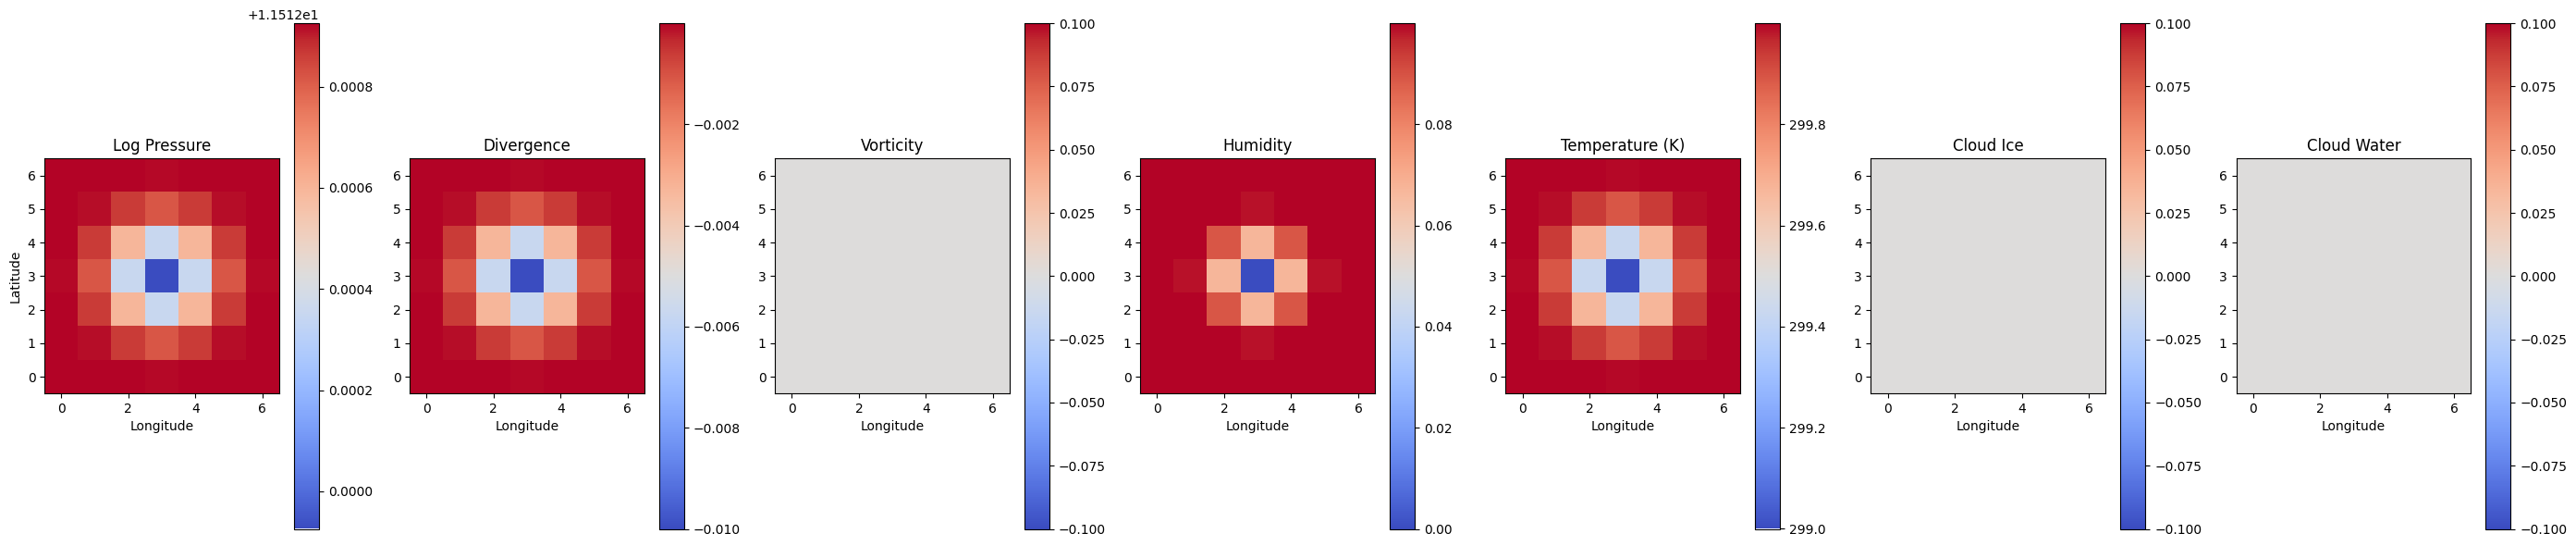

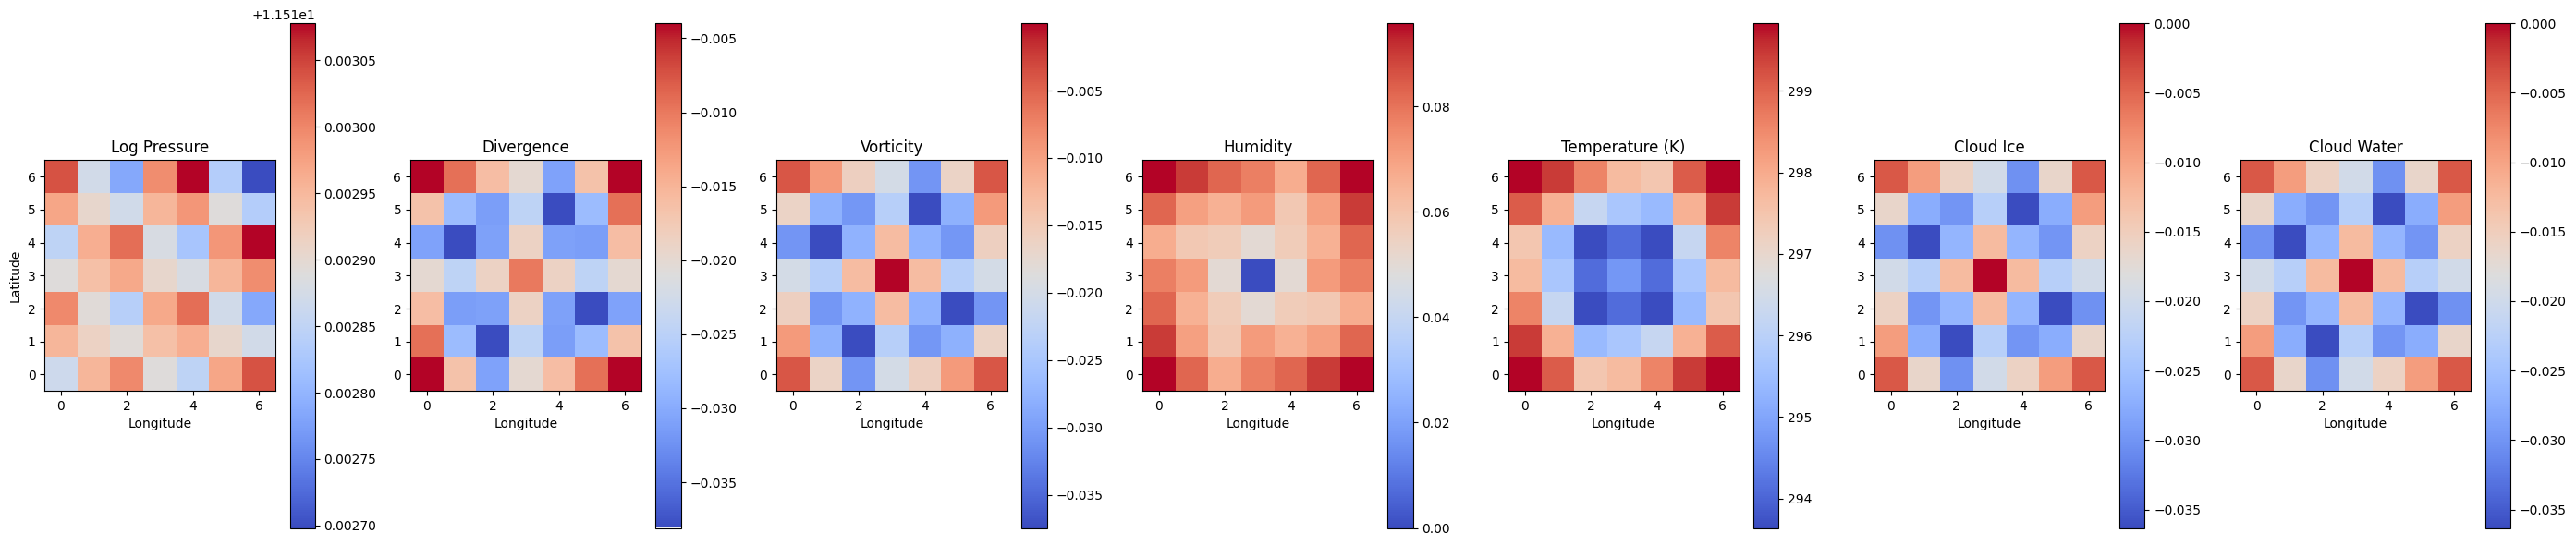

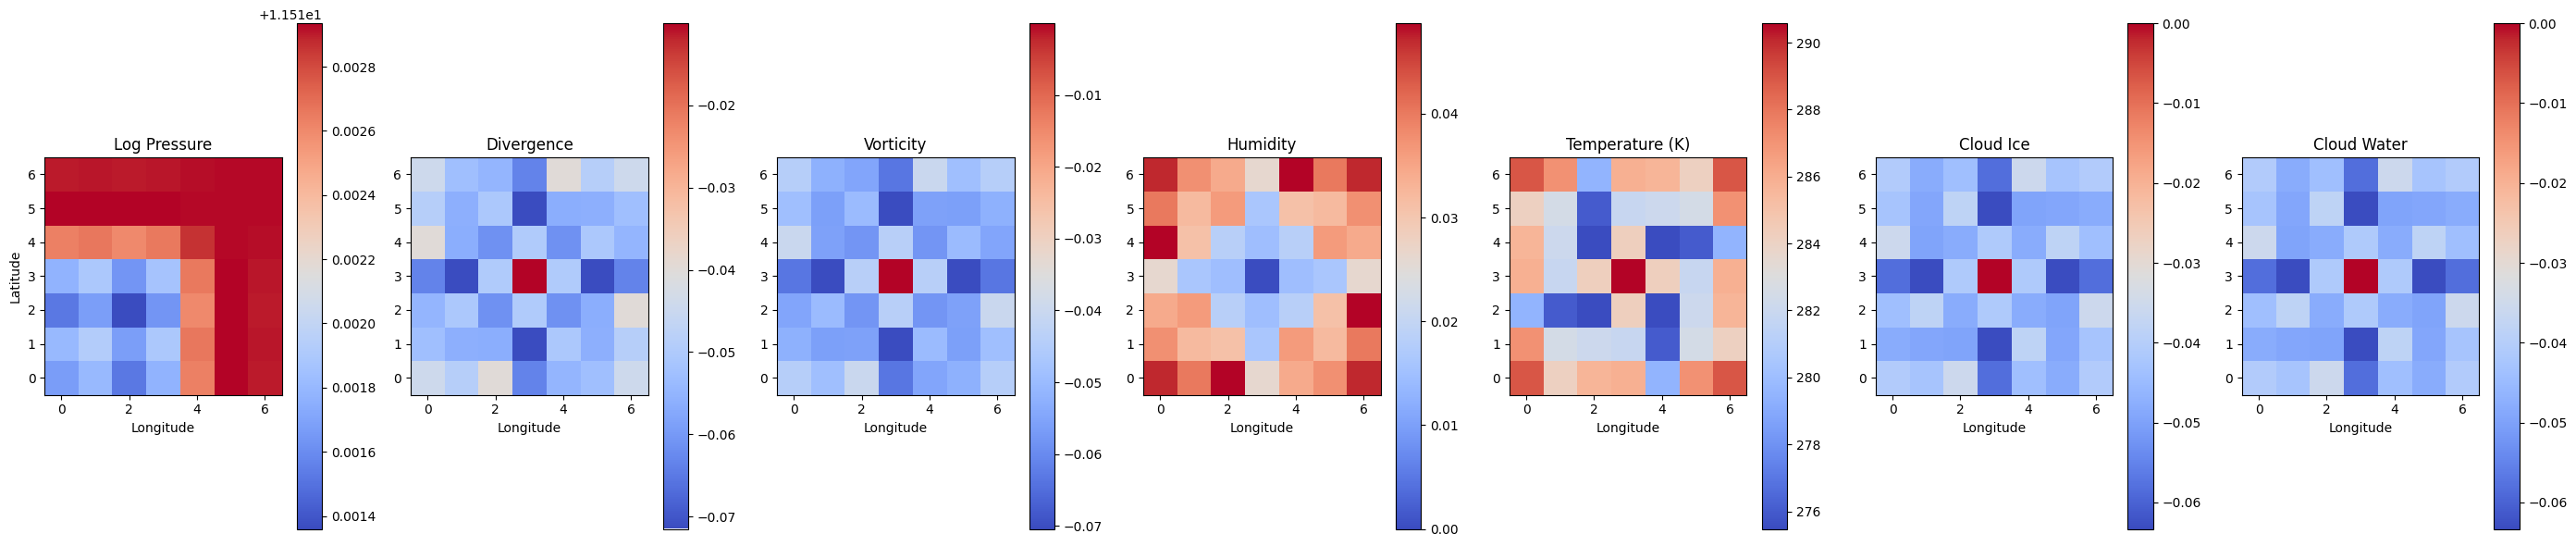

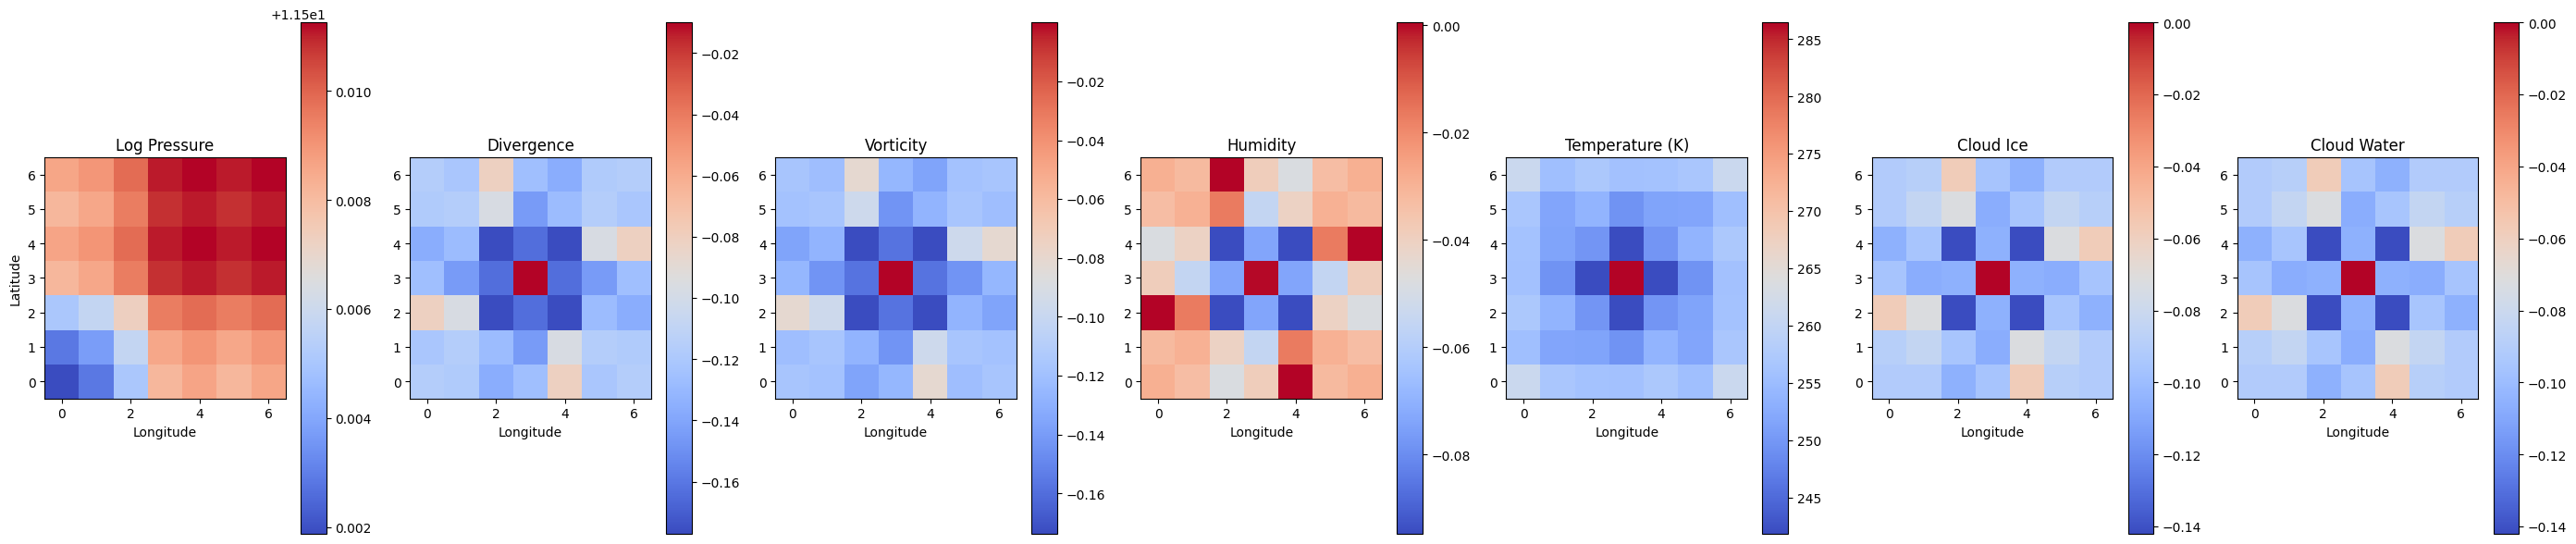

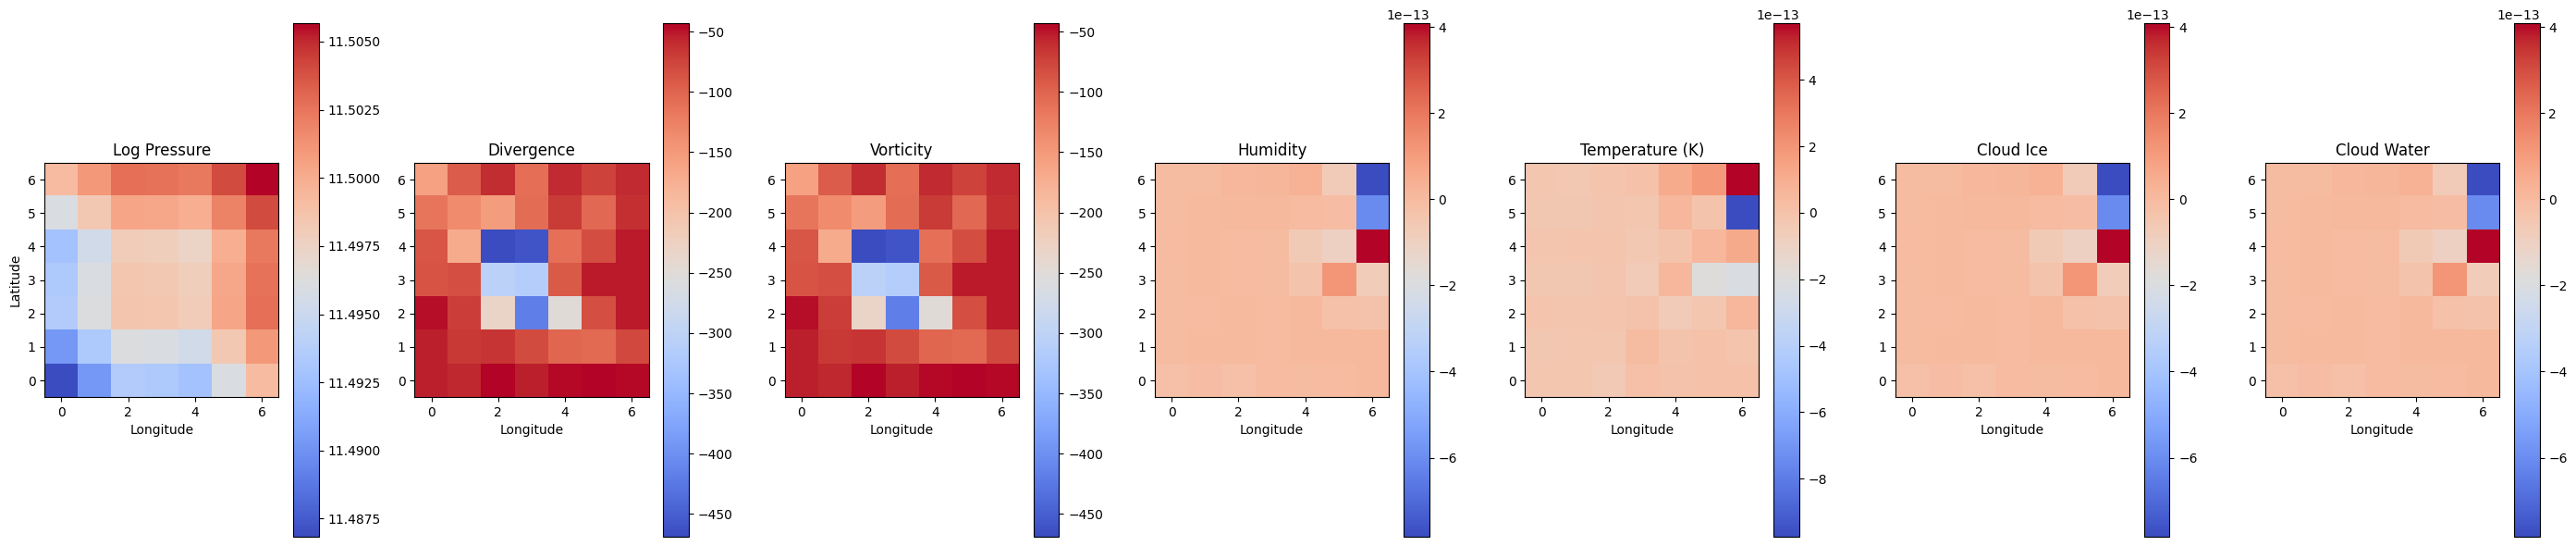

In [10]:
def visualize_all_results(result, grid_size, t_eval):
    """
    Visualise les variables pronostiques à différents instants temporels.
    """
    # Reformater les résultats pour extraire chaque variable
    divergence, vorticity, temperature, log_pressure, humidity, cloud_ice, cloud_water = result.y.reshape((7, *grid_size, -1))

    for time_index in range(5):
        # Extraction des instantanés pour chaque variable
        log_pressure_snapshot = log_pressure[:, :, time_index]
        divergence_snapshot = divergence[:, :, time_index]
        vorticity_snapshot = vorticity[:, :, time_index]
        humidity_snapshot = humidity[:, :, time_index]
        temperature_snapshot = temperature[:, :, time_index]
        cloud_ice_snapshot = cloud_ice[:, :, time_index]
        cloud_water_snapshot = cloud_water[:, :, time_index]

        # Création des sous-figures
        fig, axes = plt.subplots(1, 7, figsize=(28, 6))

        # Log Pressure
        axes[0].imshow(log_pressure_snapshot, cmap="coolwarm", origin="lower")
        axes[0].set_title("Log Pressure")
        axes[0].set_xlabel("Longitude")
        axes[0].set_ylabel("Latitude")
        fig.colorbar(axes[0].images[0], ax=axes[0])

        # Divergence
        axes[1].imshow(divergence_snapshot, cmap="coolwarm", origin="lower")
        axes[1].set_title("Divergence")
        axes[1].set_xlabel("Longitude")
        fig.colorbar(axes[1].images[0], ax=axes[1])

        # Vorticity
        axes[2].imshow(vorticity_snapshot, cmap="coolwarm", origin="lower")
        axes[2].set_title("Vorticity")
        axes[2].set_xlabel("Longitude")
        fig.colorbar(axes[2].images[0], ax=axes[2])

        # Humidity
        axes[3].imshow(humidity_snapshot, cmap="coolwarm", origin="lower")
        axes[3].set_title("Humidity")
        axes[3].set_xlabel("Longitude")
        fig.colorbar(axes[3].images[0], ax=axes[3])

        # Temperature
        axes[4].imshow(temperature_snapshot, cmap="coolwarm", origin="lower")
        axes[4].set_title("Temperature (K)")
        axes[4].set_xlabel("Longitude")
        fig.colorbar(axes[4].images[0], ax=axes[4])

        # Cloud Ice
        axes[5].imshow(cloud_ice_snapshot, cmap="coolwarm", origin="lower")
        axes[5].set_title("Cloud Ice")
        axes[5].set_xlabel("Longitude")
        fig.colorbar(axes[5].images[0], ax=axes[5])

        # Cloud Water
        axes[6].imshow(cloud_water_snapshot, cmap="coolwarm", origin="lower")
        axes[6].set_title("Cloud Water")
        axes[6].set_xlabel("Longitude")
        fig.colorbar(axes[6].images[0], ax=axes[6])

        # Ajuster l'espacement et afficher la figure
        plt.tight_layout()
        plt.show()

# Appeler la fonction pour visualiser les résultats
visualize_all_results(result, grid_size, t_eval)
